In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
print(device)

cuda:0


<h3> Loading Dataset and Applying Transforms </h3>

In [0]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])



<b>Note : </b>transforms.Normalize does the following for each of the 3 channels: image = (image - mean) / std The parameters mean, std are passed as 0.5, 0.5 in your case. This will normalize the image in the range [-1,1]. For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, the maximum value of 1 will be converted to 1


<b> Steps in Image Preprocessing </b>

<ul>
  <li>Uniform aspect ratio : Most of the neural network models assume a square shape input image, which means that each image needs to be checked if it is a square or not, and cropped appropriately </li>
  <li> Image scaling </li>
  <li> Computing mean, std dev and normalizing inputs </li>
  <li> Data augmentation </li>

</ul>

https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258

In [8]:
trainset = torchvision.datasets.CIFAR10(root = './data' , train = True, download = True , transform = transform_train)
testset = torchvision.datasets.CIFAR10(root= './data', train = False, download = True, transform = transform_test)

0it [00:00, ?it/s]

 99%|█████████▉| 169287680/170498071 [00:12<00:00, 17258974.15it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
num_classes = 10

In [0]:
batch_size = 4

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [12]:
dataiter = iter(trainloader)

images, labels = dataiter.next()

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
6


Note: The original size of CIFAR image is 32 x 32, but using the RandomResizedCrop function we changed it to 224 x 224

In [13]:
len(trainloader)

12500

In [0]:
def imshow(img, title):
    # Unnormalize the image, we multiply by 0.5 that is the std deviation, and add 0.5 which is the mean
    npimg = img.numpy() / 2 + 0.5
    plt.figure(figsize=(batch_size, 1))
    plt.axis('off')
    #Convert [3,224,224] to [224,224,3]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [0]:
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images)
    imshow(img, title=[str(x.item()) for x in labels])

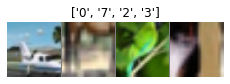

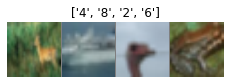

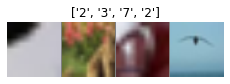

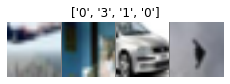

In [16]:
for i in range(4):
    show_batch_images(trainloader)

<h3>Using inbuilt VGG-16 Model </h3> 

In [0]:
from torchvision import models

In [0]:
vgg = models.vgg16_bn()

In [19]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [20]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [21]:
# out_features is 1000, but we have only 10 output features, so we should modify last layer such that number of output 
# classes is 10
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [22]:
# get number of input features in the last layer, as we do not want to change that, but only change the number of output features
final_in_features = vgg.classifier[6].in_features

# take all layers of vgg.classifier except the last layer
mod_classifier = list(vgg.classifier.children())[:-1]

# add our own layer to vgg.classier such that number of output_features equals number of classes
# number of input features in same as the removed last layer
mod_classifier.extend([nn.Linear(final_in_features, num_classes)])
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [23]:
vgg.classifier = nn.Sequential(*mod_classifier)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [0]:
batch_size = 16
# working with very large batch sizes will cause error because it occupies too much memory, 16 itself is reasonbly large

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [0]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [27]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
plt.plot(loss_epoch_arr)
plt.show()

Iteration: 0/3125, Loss: 2.47


170500096it [00:30, 17258974.15it/s]                               

Iteration: 100/3125, Loss: 2.77


KeyboardInterrupt: ignored

<b> Note: </b> Training is taking too long because of the huge number of parameters invloved while training the net, approximately 138 million. To overcome this, we use pretrained models and train only the last layer using the images in our dataset. This is known as transfer learning 

<h3> Using Pre trained Model and Transfer Learning </h3>

In [0]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
#Why shuffle false for test data
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = False)

In [0]:
#this trained model is trained on imagenet data

vgg = models.vgg16_bn(pretrained = True)

In [0]:
for param in vgg.parameters():
  param.requires_grad = False

# we have frozen the parameters by making gradients 0
# because weights are already pretrained on imagenet dataset

In [0]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [50]:
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape) # only last layer should be print as gradients has been set to zero for all other layers

torch.Size([10, 4096])
torch.Size([10])


In [0]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

Iteration: 0/3125, Loss: 2.32
Iteration: 100/3125, Loss: 1.58
Iteration: 200/3125, Loss: 1.99
Iteration: 300/3125, Loss: 1.89
Iteration: 400/3125, Loss: 1.76
Iteration: 500/3125, Loss: 1.71
Iteration: 600/3125, Loss: 3.02
Iteration: 700/3125, Loss: 1.20
Iteration: 800/3125, Loss: 1.16
Iteration: 900/3125, Loss: 1.41
Iteration: 1000/3125, Loss: 2.47
Iteration: 1100/3125, Loss: 2.11
Iteration: 1200/3125, Loss: 1.87
Iteration: 1300/3125, Loss: 2.05
Iteration: 1400/3125, Loss: 1.51
Iteration: 1500/3125, Loss: 3.60
Iteration: 1600/3125, Loss: 1.80
Iteration: 1700/3125, Loss: 2.71
Iteration: 1800/3125, Loss: 3.33
Iteration: 1900/3125, Loss: 2.37
Iteration: 2000/3125, Loss: 2.22
Iteration: 2100/3125, Loss: 1.41
Iteration: 2200/3125, Loss: 1.51
Iteration: 2300/3125, Loss: 2.30
Iteration: 2400/3125, Loss: 1.31
Iteration: 2500/3125, Loss: 3.72
Iteration: 2600/3125, Loss: 3.07
Iteration: 2700/3125, Loss: 2.46
Iteration: 2800/3125, Loss: 2.09
Iteration: 2900/3125, Loss: 1.92
Iteration: 3000/3125, 

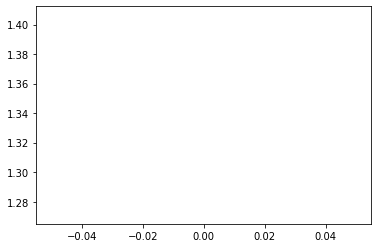

In [34]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, vgg), evaluation(trainloader, vgg)))
    
    
plt.plot(loss_epoch_arr)
plt.show()

<h3> Storing Intermediate Models </h3>

In [0]:
import copy

In [0]:
loss_epoch_arr = []

In [0]:
max_epochs = 1
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)
n_iters = np.ceil(50000/batch_size)
min_loss = 1000


In [54]:
for epoch in range(max_epochs):

  for i , data in enumerate(trainloader,0):
    inputs , labels = data
    inputs , labels = inputs.to(device), labels.to(device)

    opt.zero_grad()
    outputs = vgg(inputs)
    loss = loss_fn(outputs, labels)

    loss.backward()
    
    opt.step()
    
    if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)
        

    if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
    del inputs, labels, outputs
    torch.cuda.empty_cache()
    
  loss_epoch_arr.append(loss.item())

Min loss 2.32
Iteration: 0/3125, Loss: 2.32
Min loss 2.29
Min loss 2.06
Min loss 1.77
Min loss 1.28
Min loss 1.25
Min loss 1.17
Iteration: 100/3125, Loss: 1.51
Min loss 1.00
Min loss 0.93
Iteration: 200/3125, Loss: 1.76
Min loss 0.82
Iteration: 300/3125, Loss: 1.52
Iteration: 400/3125, Loss: 1.88
Min loss 0.65
Iteration: 500/3125, Loss: 1.99
Min loss 0.62
Iteration: 600/3125, Loss: 2.15
Iteration: 700/3125, Loss: 1.53
Iteration: 800/3125, Loss: 2.68
Iteration: 900/3125, Loss: 2.56
Iteration: 1000/3125, Loss: 2.31
Iteration: 1100/3125, Loss: 2.24
Iteration: 1200/3125, Loss: 1.02
Iteration: 1300/3125, Loss: 2.17
Iteration: 1400/3125, Loss: 2.40
Iteration: 1500/3125, Loss: 1.47
Iteration: 1600/3125, Loss: 1.59
Iteration: 1700/3125, Loss: 1.34
Iteration: 1800/3125, Loss: 1.66
Min loss 0.61
Iteration: 1900/3125, Loss: 1.19
Iteration: 2000/3125, Loss: 3.57
Iteration: 2100/3125, Loss: 1.90
Iteration: 2200/3125, Loss: 2.10
Iteration: 2300/3125, Loss: 1.83
Iteration: 2400/3125, Loss: 0.88
Itera

<b> Note:</b> Without doing opt.zero_grad() gradients will just explode

In [55]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

46.642 46.44
